<a href="https://colab.research.google.com/github/LiYuan199701/TimeSeries/blob/Bayesian-single-perceptron-TS/Three_Level_Hierarchical_Variational_Bayesian_Single_Perceptron_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Three-Level Hierarchical Variational Bayesian Single-Perceptron Time Series model

# Imports and configuration

In [1]:
# ===============================
# Bayesian single-perceptron NAR(d)
# with recency-decaying prior means
# ===============================
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
# Set inline backend and resolution
%config InlineBackend.figure_format = 'retina'  # For Retina displays
plt.rcParams['figure.dpi'] = 150  # Set dpi to 200 for high resolution

torch.manual_seed(0)
np.random.seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generate Simulated Nonlinear bounded Time Series

Text(0.5, 1.0, 'Bounded [-1,1] Time Series')

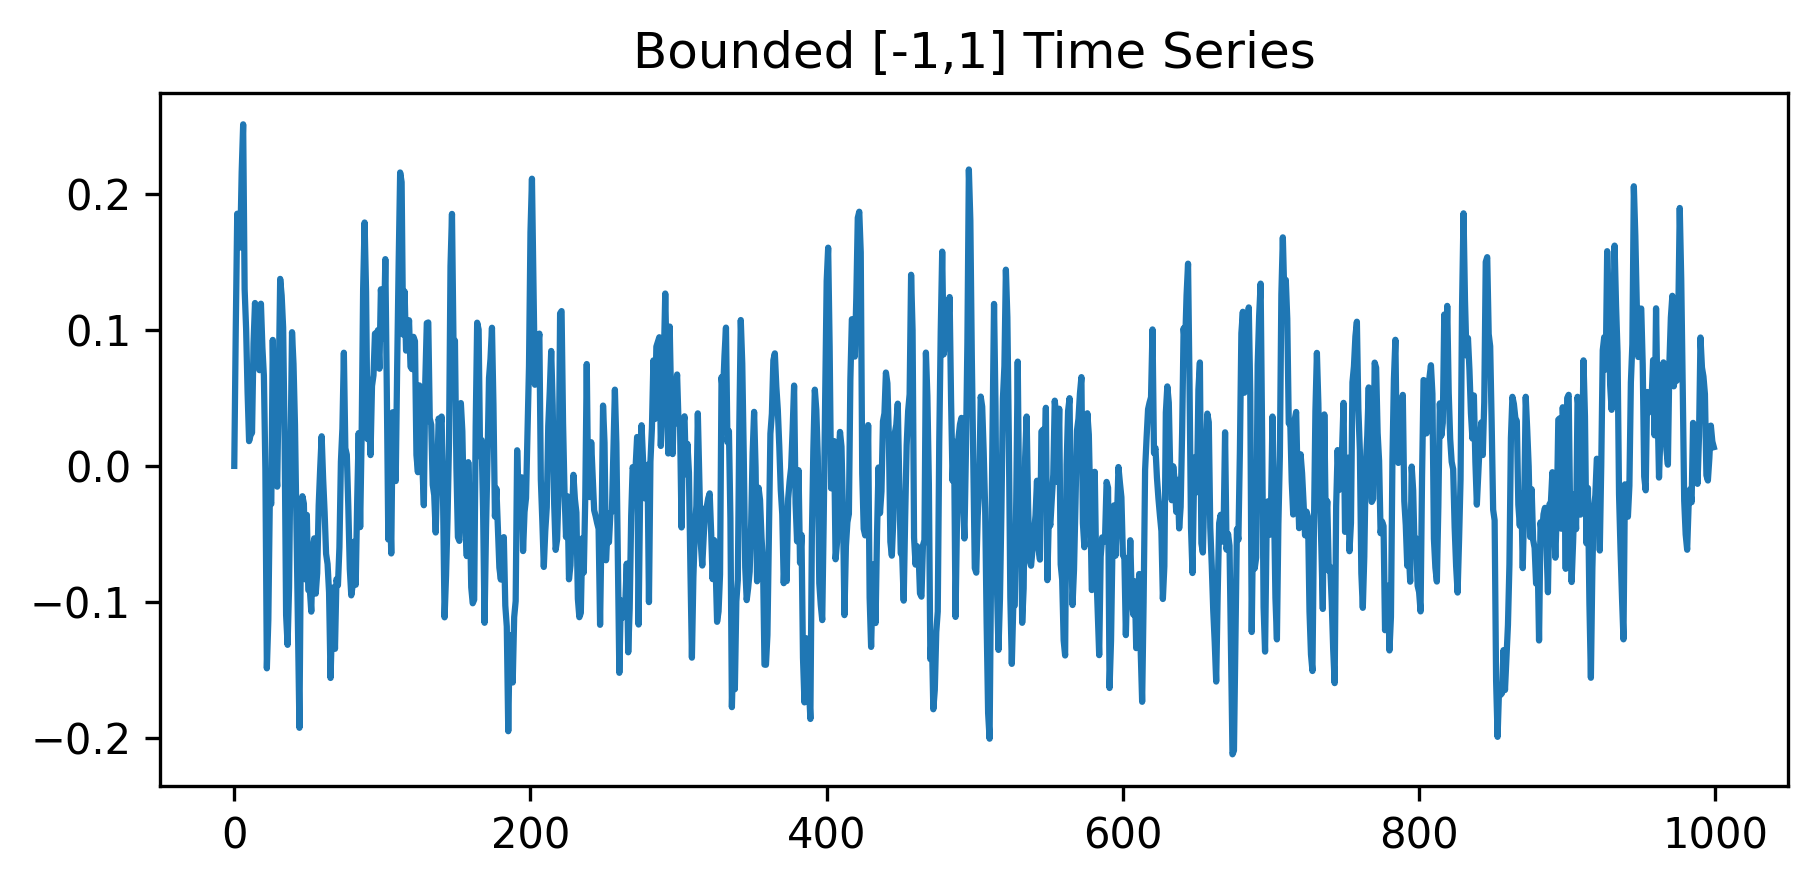

In [2]:
# -----------------------------
# 1) Simulate bounded time series
# -----------------------------
T = 1000
x = np.zeros(T)
x[0], x[1] = 0.0, 0.1
for t in range(2, T):
    x[t] = 0.7 * x[t-1] - 0.3 * x[t-2] + 0.1 * np.sin(3 * x[t-1]) + 0.05 * np.random.randn()
    x[t] = np.tanh(x[t])  # keep within [-1, 1]

# plot this time series
plt.figure(figsize=(7,3))
plt.plot(x)
plt.title("Bounded [-1,1] Time Series")

# Create lagged time series dataframe and tensor

In [3]:
# ---------------------------------
# 2) Build lagged features X_{t-1:t-d}
# ---------------------------------
def make_lagged(series, d):
    N = len(series) - d
    X = np.zeros((N, d), dtype=np.float32)
    y = np.zeros(N, dtype=np.float32)
    for i in range(N):
        # most recent first: [x_{t-1}, x_{t-2}, ..., x_{t-d}]
        X[i] = series[i:i+d][::-1]
        y[i] = series[i+d]
    return X, y

d = 4
X, y = make_lagged(x, d)
N = len(y)

# Train/val/test split by time
n_train = int(0.7*N)
n_val   = int(0.15*N)
idx_tr  = slice(0, n_train)
idx_va  = slice(n_train, n_train+n_val)
idx_te  = slice(n_train+n_val, N)

Xtr, ytr = X[idx_tr], y[idx_tr]
Xva, yva = X[idx_va], y[idx_va]
Xte, yte = X[idx_te], y[idx_te]

Xtr_t = torch.tensor(Xtr, dtype=torch.float32, device=device)
ytr_t = torch.tensor(ytr, dtype=torch.float32, device=device).unsqueeze(1)
Xva_t = torch.tensor(Xva, dtype=torch.float32, device=device)
yva_t = torch.tensor(yva, dtype=torch.float32, device=device).unsqueeze(1)
Xte_t = torch.tensor(Xte, dtype=torch.float32, device=device)
yte_t = torch.tensor(yte, dtype=torch.float32, device=device).unsqueeze(1)

# print shape and Xtr_t
print("Xtr_t shape:", Xtr_t.shape)
print(Xtr_t[:2])
print("ytr_t shape:", ytr_t.shape)
print(ytr_t[:2])
print("Xtr_t dtype:", Xtr_t.dtype)
print("Xtr_t device:", Xtr_t.device)

# form Xtr, ytr into a dataframe
df = pd.DataFrame(Xtr, columns=[f"x_{i}" for i in range(1, d+1)])
df["y"] = ytr
df.head()

Xtr_t shape: torch.Size([697, 4])
tensor([[0.1711, 0.1856, 0.1000, 0.0000],
        [0.1607, 0.1711, 0.1856, 0.1000]])
ytr_t shape: torch.Size([697, 1])
tensor([[0.1607],
        [0.2161]])
Xtr_t dtype: torch.float32
Xtr_t device: cpu


,x_1,x_2,x_3,x_4,y
0,0.171057,0.185579,0.100000,0.000000,0.160692
1,0.160692,0.171057,0.185579,0.100000,0.216112
2,0.216112,0.160692,0.171057,0.185579,0.251333
3,0.251333,0.216112,0.160692,0.171057,0.129952
4,0.129952,0.251333,0.216112,0.160692,0.100734


# Hierarchical Variational Bayesian Single-Perceptron Model

In [21]:
# ----------------------------------------------------------
# 2) Three-level VB Perceptron – only KL on weights & bias
# ----------------------------------------------------------
class VBPerceptron_KLWeightsOnly(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.d = d
        # posterior for weights
        self.m_w = nn.Parameter(torch.zeros(d))
        self.log_s_w = nn.Parameter(torch.full((d,), -1.0))
        # bias
        self.m_b = nn.Parameter(torch.tensor(0.0))
        self.log_s_b = nn.Parameter(torch.tensor(-1.0))
        # obs noise
        self.log_sigma_eps = nn.Parameter(torch.tensor(-2.0))

        # deterministic mean-decay parameters
        self.c = nn.Parameter(torch.tensor(0.5))       # broader mean amplitude
        self.lam_raw = nn.Parameter(torch.tensor(-2.0))  # sigmoid→λ≈0.27

        # stochastic variance-scale hyperparameters (τ, γ) -- no KL on them
        self.m_tau = nn.Parameter(torch.tensor(1.0))
        self.log_s_tau = nn.Parameter(torch.tensor(-0.5))
        self.m_gamma = nn.Parameter(torch.tensor(0.1))
        self.log_s_gamma = nn.Parameter(torch.tensor(-0.5))

    # ---- stable transforms ----
    def lam(self):
        return 2.0 * torch.sigmoid(self.lam_raw)  # bounds λ in (0,2)

    def sample_tau_gamma(self):
        eps_t = torch.randn(1, device=device)
        eps_g = torch.randn(1, device=device)
        tau = F.softplus(self.m_tau + torch.exp(self.log_s_tau) * eps_t) + 1e-3
        gam = self.m_gamma + torch.exp(self.log_s_gamma) * eps_g
        return tau, gam

    def prior_mean_var(self, tau, gam):
        k = torch.arange(1, self.d+1, dtype=torch.float64, device=device)
        mu_p = torch.clamp(self.c, min=0.1) * torch.exp(-self.lam() * (self.d - k))
        sigma_p = torch.clamp(1.0 + 2.0 * tau * torch.exp(gam * (self.d - k)), min=0.5)
        return mu_p, sigma_p


    def kl_normal(self, mu_q, log_s_q, mu_p, sigma_p):
        sigma_q = torch.exp(log_s_q)
        term = (sigma_q**2 + (mu_q - mu_p)**2) / (sigma_p**2)
        kl = 0.5 * torch.sum(torch.log(sigma_p**2/sigma_q**2) + term - 1)
        return kl

    def forward(self, X, sample=True):
        # sample tau, gamma but don't regularize them
        tau, gam = self.sample_tau_gamma() if sample else (F.softplus(self.m_tau), self.m_gamma)
        mu_p, sigma_p = self.prior_mean_var(tau, gam)

        # sample weights & bias
        eps_w = torch.randn(self.d, device=device)
        w = self.m_w + torch.exp(self.log_s_w) * eps_w if sample else self.m_w
        eps_b = torch.randn(1, device=device)
        b = self.m_b + torch.exp(self.log_s_b) * eps_b if sample else self.m_b

        # forward
        yhat = torch.tanh(X @ w + b)
        sigma_eps = F.softplus(self.log_sigma_eps)

        # KL only for weights + bias
        kl_w = self.kl_normal(self.m_w, self.log_s_w, mu_p, sigma_p)
        kl_b = self.kl_normal(self.m_b, self.log_s_b, torch.tensor(0., device=device), torch.tensor(1., device=device))
        kl_total = kl_w + kl_b

        return yhat, sigma_eps, kl_total

# Define ELBO with MC and Train function

In [22]:
# ----------------------------------------------------------
# 3) ELBO + training loop
# ----------------------------------------------------------
def elbo_step(model, X, y, num_samples=3, beta=1.0):
    total_nll, total_kl = 0.0, 0.0
    for _ in range(num_samples):
        yhat, sigma_eps, kl = model(X, sample=True)
        nll = 0.5 * (((y - yhat)**2)/(sigma_eps**2) + 2*torch.log(sigma_eps)).sum()
        total_nll += nll
        total_kl += kl
    nll = total_nll / num_samples
    kl  = total_kl / num_samples
    reg = 0.1 * ((model.c - 0.5)**2 + (F.softplus(model.m_tau) - 1.0)**2 + (model.m_gamma - 0.0)**2)
    loss = nll + beta * kl + reg
    mse_like = ((y - yhat)**2).mean().detach()
    return loss, nll.detach(), kl.detach(), mse_like

def train_model(model, Xtr, ytr, Xva, yva,
                epochs=800, lr=3e-3, mc=3,
                beta_start=0.01, beta_end=1.0, beta_warmup=800, verbose=True):
    opt = torch.optim.Adam([
        {'params': [model.m_w, model.log_s_w, model.m_b, model.log_s_b,
                    model.log_sigma_eps, model.c, model.lam_raw], 'lr': lr},
        {'params': [model.m_tau, model.log_s_tau, model.m_gamma, model.log_s_gamma], 'lr': lr*5}
    ])
    hist = {"train_mse": [], "val_mse": [], "beta": []}
    for ep in range(1, epochs+1):
        beta = beta_end if ep >= beta_warmup else beta_start + (beta_end-beta_start)*ep/beta_warmup
        model.train()
        opt.zero_grad()
        loss, nll, kl, mse = elbo_step(model, Xtr, ytr, num_samples=mc, beta=beta)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        opt.step()
        model.eval()
        with torch.no_grad():
            yhat_va, _, _ = model(Xva, sample=False)
            val_mse = ((yva - yhat_va)**2).mean().item()
        hist["train_mse"].append(mse.item())
        hist["val_mse"].append(val_mse)
        hist["beta"].append(beta)
        if verbose and ep % 100 == 0:
            print(f"Epoch {ep:4d} | β={beta:.3f} | train MSE={mse.item():.4f} | val MSE={val_mse:.4f}")
    return hist

# Train the model with data

Epoch  100 | β=0.067 | train MSE=0.0367 | val MSE=0.0051
Epoch  200 | β=0.134 | train MSE=0.0183 | val MSE=0.0054
Epoch  300 | β=0.200 | train MSE=0.0084 | val MSE=0.0053
Epoch  400 | β=0.267 | train MSE=0.0238 | val MSE=0.0056
Epoch  500 | β=0.334 | train MSE=0.0161 | val MSE=0.0059
Epoch  600 | β=0.400 | train MSE=0.0081 | val MSE=0.0052
Epoch  700 | β=0.467 | train MSE=0.0099 | val MSE=0.0055
Epoch  800 | β=0.534 | train MSE=0.0142 | val MSE=0.0056
Epoch  900 | β=0.600 | train MSE=0.0068 | val MSE=0.0053
Epoch 1000 | β=0.667 | train MSE=0.0073 | val MSE=0.0053
Epoch 1100 | β=0.733 | train MSE=0.0079 | val MSE=0.0054
Epoch 1200 | β=0.800 | train MSE=0.0065 | val MSE=0.0053
Epoch 1300 | β=0.867 | train MSE=0.0070 | val MSE=0.0053
Epoch 1400 | β=0.933 | train MSE=0.0066 | val MSE=0.0053
Epoch 1500 | β=1.000 | train MSE=0.0065 | val MSE=0.0052

✅ Test MSE: 0.0061


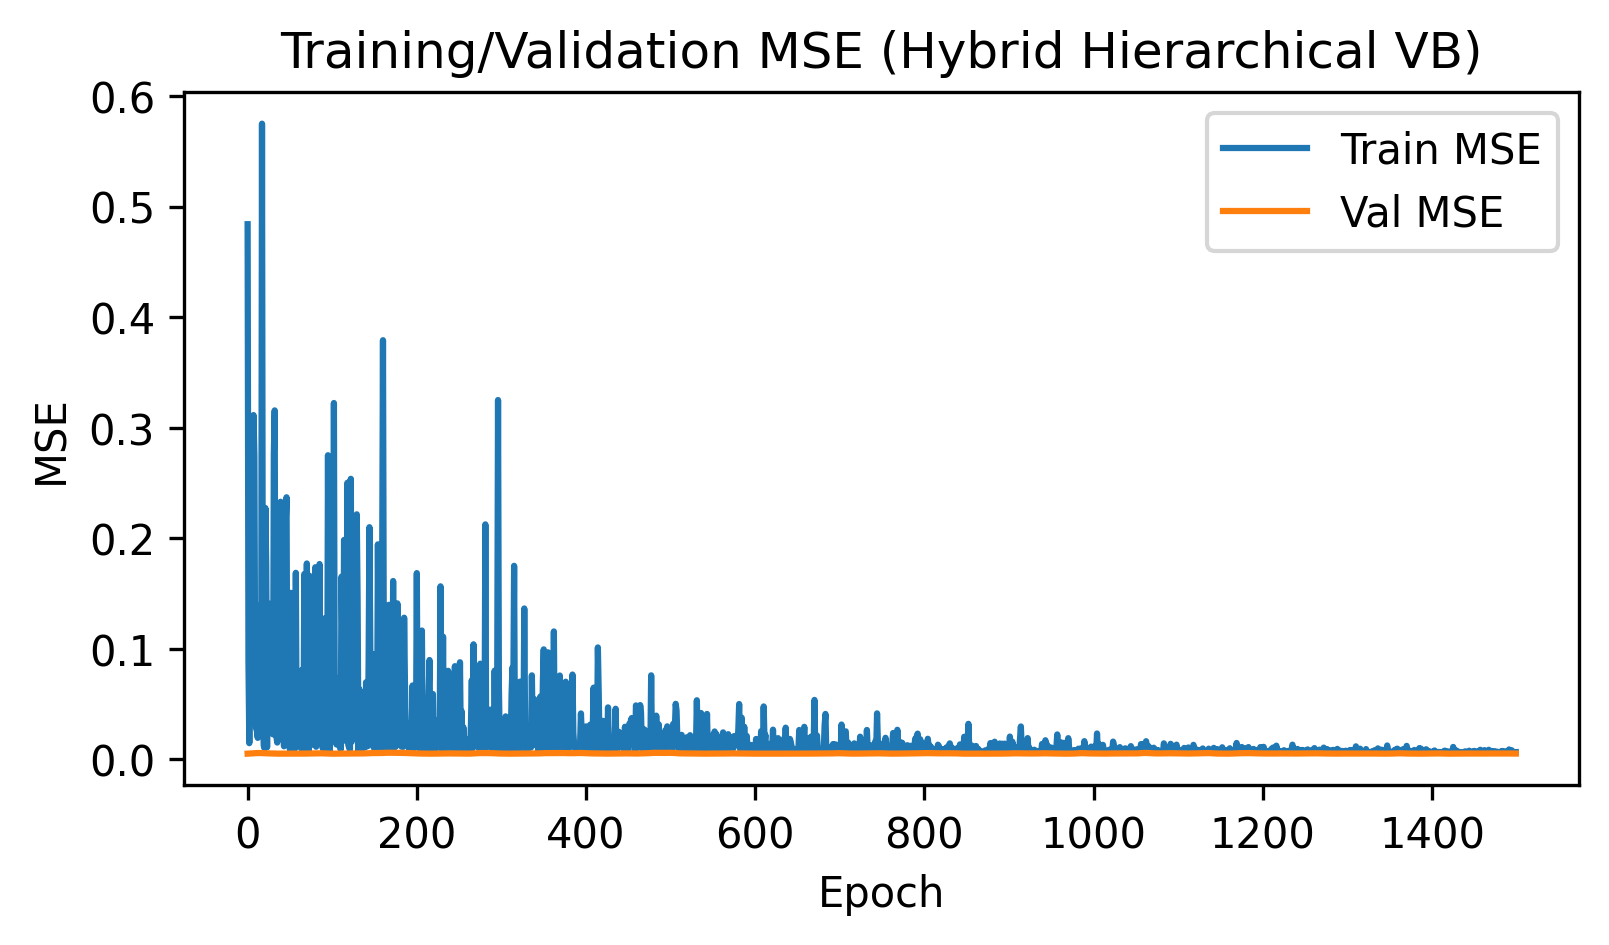

In [23]:
# ----------------------------------------------------------
# 4) Train
# ----------------------------------------------------------
model = VBPerceptron_KLWeightsOnly(d).to(device)
hist = train_model(model, Xtr_t, ytr_t, Xva_t, yva_t,
                   epochs=1500, lr=3e-3, mc=5,
                   beta_start=0.0005, beta_end=1.0, beta_warmup=1500)


# ----------------------------------------------------------
# 5) Evaluate + visualize weights
# ----------------------------------------------------------
model.eval()
with torch.no_grad():
    yhat_te, _, _ = model(Xte_t, sample=False)
    test_mse = ((yte_t - yhat_te)**2).mean().item()
print(f"\n✅ Test MSE: {test_mse:.4f}")

plt.figure(figsize=(6,3))
plt.plot(hist["train_mse"], label="Train MSE")
plt.plot(hist["val_mse"], label="Val MSE")
plt.xlabel("Epoch"); plt.ylabel("MSE")
plt.legend(); plt.title("Training/Validation MSE (Hybrid Hierarchical VB)")
plt.show()

# Predictive Uncertainty

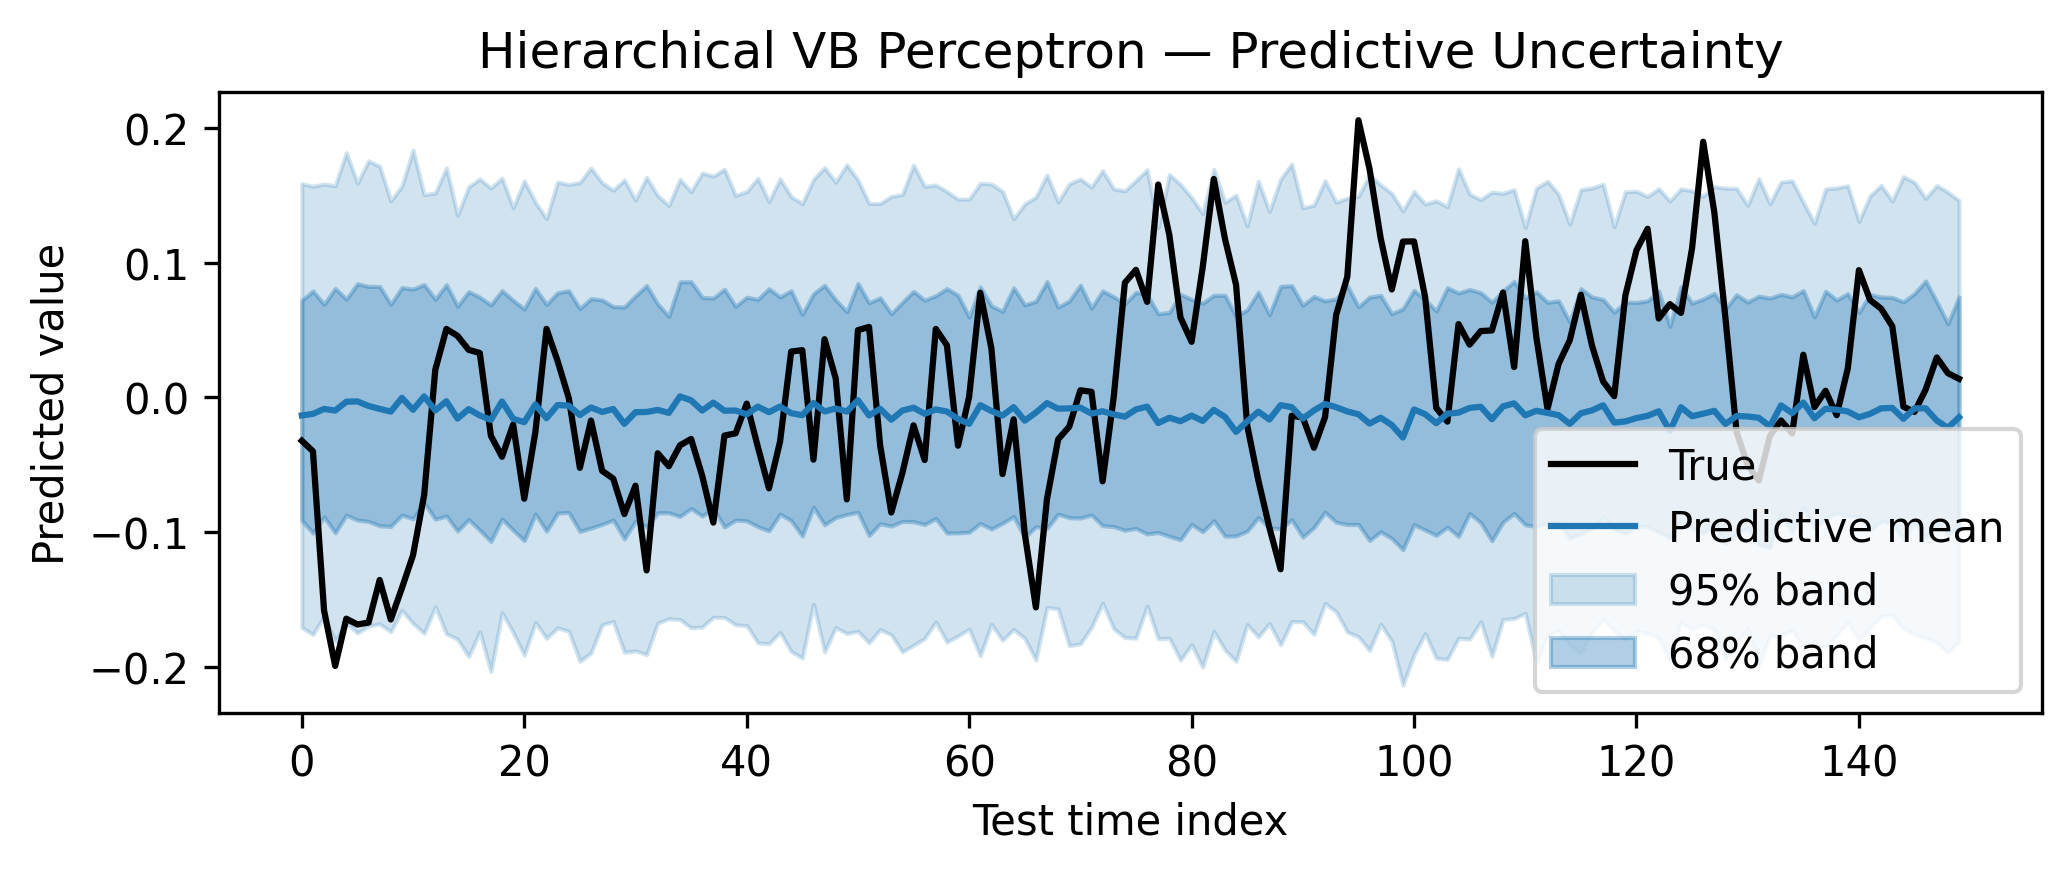

Test MSE (mean prediction): 0.0064


In [24]:
# ==========================================================
# 9) Monte Carlo Predictive Sampling and Visualization
# ==========================================================
import numpy as np
import matplotlib.pyplot as plt

@torch.no_grad()
def predict_mc(model, X, n_samples=400, include_obs_noise=True):
    model.eval()
    preds = []
    for _ in range(n_samples):
        yhat, sigma_eps, _ = model(X, sample=True)
        if include_obs_noise:
            yhat = yhat + sigma_eps * torch.randn_like(yhat)
        preds.append(yhat.reshape(-1).cpu().numpy())  # ✅ robust reshape
    P = np.stack(preds, axis=0)  # [S, N]
    mean = P.mean(axis=0)
    lo95, hi95 = np.percentile(P, [2.5, 97.5], axis=0)
    lo68, hi68 = np.percentile(P, [16.0, 84.0], axis=0)
    return mean, (lo68, hi68), (lo95, hi95)


# ---- Run MC predictive inference ----
mean_hvb, (lo68, hi68), (lo95, hi95) = predict_mc(model, Xte_t, n_samples=400, include_obs_noise=True)
y_true = yte_t.squeeze(1).cpu().numpy()

# ==========================================================
# 10) Plot full test prediction with uncertainty
# ==========================================================
plt.figure(figsize=(7,3))
plt.plot(y_true, label="True", color="black")
plt.plot(mean_hvb, label="Predictive mean", color="C0")
plt.fill_between(np.arange(len(y_true)), lo95, hi95, alpha=0.2, color="C0", label="95% band")
plt.fill_between(np.arange(len(y_true)), lo68, hi68, alpha=0.35, color="C0", label="68% band")
plt.title("Hierarchical VB Perceptron — Predictive Uncertainty")
plt.xlabel("Test time index")
plt.ylabel("Predicted value")
plt.legend()
plt.tight_layout()
plt.show()
# ---- Compute numeric MSE ----
mse_test = np.mean((mean_hvb - y_true)**2)
print(f"Test MSE (mean prediction): {mse_test:.4f}")

# Diagonostics

In [15]:
model.m_w

Parameter containing:
tensor([ 0.0011,  0.0033,  0.0004, -0.0071], requires_grad=True)

In [16]:
model.m_b

Parameter containing:
tensor(-0.0125, requires_grad=True)

In [20]:
print("c =", model.c.item(), "lambda =", model.lam().item())
tau, gamma = model.sample_tau_gamma()
print("tau =", tau.item(), "gamma =", gamma.item())
mu_p, sigma_p = model.prior_mean_var(tau, gamma)
print("Prior means:", mu_p.detach().cpu().numpy())
print("Prior stds :", sigma_p.detach().cpu().numpy())

c = 0.01000993326306343 lambda = 0.611522376537323
tau = 0.002420465461909771 gamma = -2.9937849044799805
Prior means: [0.00159841 0.00294625 0.00543063 0.01000993]
Prior stds : [0.5000003  0.50000607 0.50012126 0.50242047]
